# Running ABC Model

## Input files 
1. Input files used 
2. Other Input files used in cellTypeParameters.txt and genomes.txt 
3. How the genes file was curated 
4. Getting enhancer regions from DHS peak files 
5. Processing Hi-C files 

1. Input files 
Datafiles used: 

DHS files: ENCFF658OKV, ENCFF372IZN
DNase_files: ENCFF246VVI
H3K27ac files: ENCFF384ZZM
HI-C files: GSE63525
 

For the DNase and H3K27ac files, one replicate file was used -- recommended by Joseph 

2. Other Input files used in :

cellTypeParameters.txt : example/input_data/Expression/K562.featureCounts.RPKM.txt

genomes.txt : example/config/UbiquitouslyExpressedGenesHG19.txt

3. Curating the --genes file: 
downloaded from: http://hgdownload.soe.ucsc.edu/goldenPath/hg19/database/refGene.txt.gz 

- removed any alt chr_ 
- removed MIR genes 
- picked the isoform with the smallest ID number (recommended by Joseph) 

For example: <br>
chr3	57742982	57915741	SLMAP;NM_001304420	0	+ <br>
chr3	57742982	57915741	SLMAP;NM_001304421	0	+ <br>
    chr3	57742982	57915741	SLMAP;NM_007159	0	+ <br>
chr3	57875640	57915741	SLMAP;NM_001311178	0	+ <br>
chr3	57875640	57915741	SLMAP;NM_001304423	0	+ <br>
chr3	57875640	57904209	SLMAP;NM_001311179	0	+ <br>
chr3	57875640	57915741	SLMAP;NM_001304422	0	+ <br>

We would pick the first row since the NM_ID is the lowest. 

4. Getting Enhancer Candidate Regions 
Used both replicates of the DHS files

First, I converted BigBed to bed by using the utility downloaded from: http://hgdownload.cse.ucsc.edu/admin/exe/linux.x86_64/.

Next, ran the commands : 
chmod +x bigBedToBed & ./bigBedToBed
cat *.bed > merged.bed
sort -k1,1 -k2,2n merged.bed > merged.sorted.bed
bedtools slop -b 175 -i example/input_data/Chromatin/mergedPeaks.bed -g example/config/chrom.sizes.bed | bedtools merge -i stdin > example/input_data/Chromatin/wgEncodeUwDnaseK562.mergedPeaks.slop175.bed

In the paper, this generated ~175k but I got ~220k candidate peaks 

5. Getting Hi-C bedgraph files: 
Used code via ABC-code github

python src/make_bedgraph_from_HiC.py \
--outdir $HICDIR/bedgraph/ \
--genes example/config/RefSeqCurated.170308.chr22.small.bed \
--hic_dir $HICDIR/raw/5kb_resolution_intrachromosomal/

## Quantifying Enhancer Activity
used the commands in the github repo

In [ ]:
python src/run.neighborhoods.py \
--cellType K562 \
--params_file example/config/cellTypeParameters.txt \
--outdir $NBHDDIR \
--genome example/config/genomes.txt \
--candidate_enhancer_regions example/input_data/Chromatin/wgEncodeUwDnaseK562.mergedPeaks.chr22.slop175.bed \
--genes example/config/RefSeqCurated.170308.chr22.small.bed

## Predicting Enh-Gene Pairs
used the commands in the github repo 

In [ ]:
python src/predict.py \
--cellType K562 \
--params_file example/config/cellTypeParameters.txt \
--outdir $PREDDIR \
--HiCdir example/input_data/HiC/bedgraph/ \
--nbhd_directory $NBHDDIR \
--threshold .022

# Runtime
1. Quantifying Enhancer Activity
~ Runtime : 156.1910161972046 ~ 2.6 min

2. Making predictions 
~ 15 hours for 23 chromosomes and 23k genes

# Analysis for K562

In [2]:
import pandas as pd
# Jesse's Predictions 
actual_data = pd.read_csv("../ABC/actual_K562.csv")
ac_data = actual_data[['chr', 'start', 'end', 'TargetGene', 'TargetGeneTSS', 'Normalized_HiC_Contacts', 'Activity', 'ABC_Score']]

In [32]:
# List of unique genes 
unique_genes = ac_data[['TargetGene', 'TargetGeneTSS']].drop_duplicates()
#print(unique_genes)
#print(unique_genes[:5])
#print(len(ac_data))

In [7]:
# My predictions
data_6may = pd.read_csv("../EnhancerPredictions/EnhancerPredictions_6May.txt", sep='\t')
data_6 = data_6may[['chr', 'start', 'end', 'TargetGene', 'TargetGeneTSS','class','hic.distance.adj', 'activity_base', 'ABC.Score']]

In [8]:
data_6 = data_6.drop_duplicates(['chr', 'start', 'end', 'TargetGene','TargetGeneTSS', 'ABC.Score'])
#print(len(data_6))

## Looking at individual ABC Scores and comparing them 

I started looking at individual genes. 
For genes where relatively similar enhancer regions were picked, there are variations in the ABC Scores observed

For the following evaluation, note that: 
ac_data refers to Jesse's Table S6 results 
data_6 refers to my scores 

In [14]:
ac_data.loc[(ac_data['TargetGene']==unique_genes_1[150])]

,chr,start,end,TargetGene,TargetGeneTSS,Normalized_HiC_Contacts,Activity,ABC_Score
531,chr1,22773985.0,22774485.0,ZBTB40,22778343.0,100.0000,1.7324,0.0345
532,chr1,22780945.0,22781445.0,ZBTB40,22778343.0,90.0543,2.6998,0.0484


In [15]:
data_6.loc[data_6['TargetGene']==unique_genes_1[150]]

,chr,start,end,TargetGene,TargetGeneTSS,class,hic.distance.adj,activity_base,ABC.Score
630,chr1,22780920,22781420,ZBTB40,22778343,genic,90.1236,2.5432,0.0474
631,chr1,22774000,22774500,ZBTB40,22778343,intergenic,100.0000,1.4955,0.0309


In [16]:
ac_data.loc[(ac_data['TargetGene']==unique_genes_1[300])]

,chr,start,end,TargetGene,TargetGeneTSS,Normalized_HiC_Contacts,Activity,ABC_Score
944,chr1,41329145.0,41330125.0,ZFP69B,40916336.0,7.9089,27.4543,0.0287
945,chr1,40848745.0,40850525.0,ZFP69B,40916336.0,9.9176,46.0081,0.0604


In [17]:
data_6.loc[data_6['TargetGene']==unique_genes_1[300]]

,chr,start,end,TargetGene,TargetGeneTSS,class,hic.distance.adj,activity_base,ABC.Score
1176,chr1,40848778,40849660,ZFP69B,40916147,genic,9.9869,31.4766,0.0443
1177,chr1,41329180,41330160,ZFP69B,40916147,intergenic,7.9782,25.0622,0.0282


Genes that have vastly different enhancer regions - like S100PBP and LINC01128 for example

For S100PBP,  my predictions would pick out more enhancer regions 
- Joseph ran the analysis & it picked out similar enhancer regions so the variation could be the result of me picking out isoforms based on the smallest ID number as mentioned above (*see attached image.png) 

In [18]:
ac_data.loc[(ac_data['TargetGene']=='S100PBP')]

,chr,start,end,TargetGene,TargetGeneTSS,Normalized_HiC_Contacts,Activity,ABC_Score
822,chr1,33279825.0,33281625.0,S100PBP,33290913.0,41.2847,7.3393,0.0543


In [19]:
data_6.loc[data_6['TargetGene']=='S100PBP']

,chr,start,end,TargetGene,TargetGeneTSS,class,hic.distance.adj,activity_base,ABC.Score
994,chr1,33280280,33280780,S100PBP,33283042,genic,100.0,2.9175,0.0378
995,chr1,33279760,33280260,S100PBP,33283042,genic,100.0,2.8076,0.0364
996,chr1,33284380,33284880,S100PBP,33283042,genic,100.0,1.9238,0.0249


For LINC01128, 

Joseph ran the analysis and said he also got similar results, but the enhancer-regions that I got that didn't show up in the Table S6 results had scores below 0.02 and were omitted. 

It also seems like for LINC01128 though, the enhancer regions picked are so different. 

In [20]:
ac_data.loc[(ac_data['TargetGene']=='LINC01128')]

,chr,start,end,TargetGene,TargetGeneTSS,Normalized_HiC_Contacts,Activity,ABC_Score
4,chr1,761105.0,761605.0,LINC01128,762970.0,100.0,0.4501,0.0287


In [21]:
data_6.loc[data_6['TargetGene']=='LINC01128']

,chr,start,end,TargetGene,TargetGeneTSS,class,hic.distance.adj,activity_base,ABC.Score
7,chr1,1283240,1283780,LINC01128,762970,genic,8.0552,3.9409,0.0225
8,chr1,999120,1000000,LINC01128,762970,genic,5.3262,8.0474,0.0304
9,chr1,937080,937580,LINC01128,762970,intergenic,16.5575,2.2449,0.0263
10,chr1,1240860,1241860,LINC01128,762970,genic,4.3200,8.4652,0.0259


Looking at Mean and Stdev across all examples

In [12]:
ac_mean = np.mean(ac_data['ABC_Score'])
ac_stddev = np.std(ac_data['ABC_Score'])
mean_6 = np.mean(data_6['ABC.Score'])
stddev_6 = np.std(data_6['ABC.Score'])
results = {'Jesse_mean': ac_mean, 'Jesse_stddev': ac_stddev, 'mean': mean_6, 'stddev': stddev_6 }
results = pd.DataFrame(results, index=[0])
print(results)

   Jesse_mean  Jesse_stddev     mean    stddev
0     0.05514      0.042203  0.05315  0.043699


Comparing between ABC scores and differences in ABC scores 
I wanted to see the distribution of differences between Jesse's and my ABC scores

In [25]:
import numpy as np
genes_not_compared=[]
difference=[]
diff_hic=[]
diff_activity=[]
actual_scores_total = []
my_scores=[]
gene=[]
gene_tss=[]
for i in unique_genes['TargetGene']: 
    ac_match = ac_data.loc[(ac_data['TargetGene']==i)]
    match = data_6.loc[data_6['TargetGene']==i]
    if len(ac_match)==len(match): 
        gene.append([i] *len(ac_match))
        gene_tss.append(match['TargetGeneTSS'] *len(ac_match))
        ac_score = np.sort(ac_match['ABC_Score'])
        actual_scores_total.append(ac_score)
        score = np.sort(match['ABC.Score'])
        my_scores.append(score)
        ac_hic_distance = np.sort(ac_match['Normalized_HiC_Contacts'])
        hic_distance = np.sort(match['hic.distance.adj'])
        ac_ac_base = np.sort(ac_match['Activity'])
        ac_base = np.sort(match['activity_base'])
        diff1 = ac_hic_distance-hic_distance
    #print(diff1)
        diff2 = ac_ac_base - ac_base
    #print(diff2)
        diff_hic.append(diff1)
        diff_activity.append(diff2) 
    elif len(match) & len(ac_match)!= None:
        if len(match) < len(ac_match):
            ac_match = ac_match[:len(match)]
            
        else: 
            match = match[:len(ac_match)]
        score = np.sort(match['ABC.Score'])
        my_scores.append(score)
        ac_score = np.sort(ac_match['ABC_Score'])
        actual_scores_total.append(ac_score)
        ac_hic_distance = np.sort(ac_match['Normalized_HiC_Contacts'])
        hic_distance = np.sort(match['hic.distance.adj'])
        ac_ac_base = np.sort(ac_match['Activity'])
        ac_base = np.sort(match['activity_base'])
    else: 
        genes_not_compared.append(i)

In [26]:
actual_scores = [i for sublist in actual_scores_total for i in sublist]
scores = [i for sublist in my_scores for i in sublist]

In [27]:
print(len(actual_scores))
print(len(scores))
print(len(genes_not_compared))

28172
28172
0


# Correlation Graph between K_ABC Scores and J_ABC Scores 

In [45]:
# plot on WashU 

x=actual_scores
y=scores
#plt.xscale('log')
#plt.yscale('log')

In [34]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as st 

# Eval gaussian kde on regular grid of nbins * nbins over data
nbins = 400
actual_scores_1 = np.asarray(actual_scores)
scores_1 = np.asarray(scores)


k = st.gaussian_kde([actual_scores_1, scores_1])
xi, yi = np.mgrid[actual_scores_1.min():actual_scores_1.max():nbins*1j, scores_1.min():scores_1.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


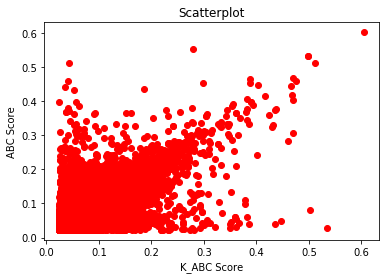

In [46]:

plt.xlabel('K_ABC Score')
plt.ylabel('ABC Score')
plt.title('Scatterplot')
plt.plot(x, y, 'ro')

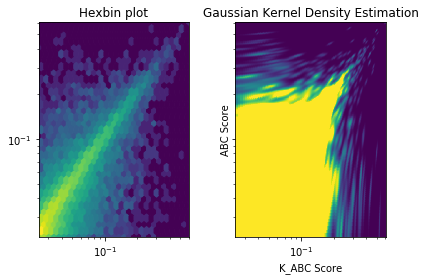

In [47]:
# Make plot 
fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True)
#plt.scatter(actual_scores, scores, s=6)
plt.xlabel('K_ABC Score')
plt.ylabel('ABC Score')
nbins=30

axes[0].set_title('Hexbin plot')
axes[0].hexbin(x, y, gridsize=nbins, bins='log',xscale='log', yscale='log')
axes[1].set_title('Gaussian Kernel Density Estimation')
axes[1].pcolormesh(xi,yi,zi.reshape(xi.shape), vmin=0, vmax=1)
fig.tight_layout()

In [339]:
import scipy.stats

print("Pearson_correlation: {}".format(scipy.stats.pearsonr(actual_scores_1, scores_1)))
print("Spearman_correlation: {}".format(scipy.stats.spearmanr(actual_scores_1,scores_1)))

Pearson_correlation: (0.7574690672863612, 0.0)
Spearman_correlation: SpearmanrResult(correlation=0.7523188523031518, pvalue=0.0)


## Histogram plots of differences 

(array([  57.,   68.,   64.,   76.,   78.,   83.,   84.,  116.,  105.,
          86.,  120.,  168.,  143.,  175.,  198.,  184.,  267.,  301.,
         298.,  375.,  376.,  438.,  510.,  646.,  806.,  884., 1067.,
        1173., 1339., 1469., 1561., 1520., 1422., 1189.,  934.,  841.,
         744.,  618.,  520.,  446.,  378.,  326.,  313.,  291.,  257.,
         221.,  198.,  185.,  157.,  148.,  135.,  107.,  117.,  117.,
         109.,  103.,   93.,   87.,   77.]),
 array([-3.00000000e-02, -2.90000000e-02, -2.80000000e-02, -2.70000000e-02,
        -2.60000000e-02, -2.50000000e-02, -2.40000000e-02, -2.30000000e-02,
        -2.20000000e-02, -2.10000000e-02, -2.00000000e-02, -1.90000000e-02,
        -1.80000000e-02, -1.70000000e-02, -1.60000000e-02, -1.50000000e-02,
        -1.40000000e-02, -1.30000000e-02, -1.20000000e-02, -1.10000000e-02,
        -1.00000000e-02, -9.00000000e-03, -8.00000000e-03, -7.00000000e-03,
        -6.00000000e-03, -5.00000000e-03, -4.00000000e-03, -3.00000000e-0

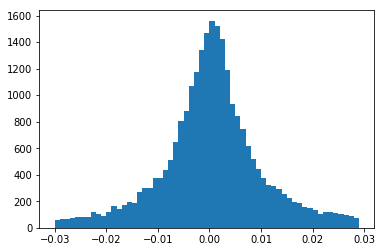

In [260]:
from matplotlib import pyplot as plt
import numpy as np

differences = np.array(actual_scores) - np.array(scores)
plt.hist(differences, bins=np.arange(-0.03,0.03, 0.001))

## Histogram of absolute differences

(array([2926., 2912., 2649., 2220., 1846., 1667., 1406., 1053.,  976.,
         837.,  758.,  627.,  619.,  557.,  417.,  413.,  395.,  326.,
         330.,  264.,  223.,  205.,  240.,  198.,  194.,  181.,  174.,
         146.,  145.,  132.,  119.,  119.,   97.,  103.,   77.,   80.,
          81.,   80.,   78.,   64.,   84.,   77.,   70.,   48.,   57.,
          64.,   66.,   56.,   49.,   56.,   49.,   43.,   50.,   40.,
          32.,   36.,   33.,   33.,   28.,   26.,   40.,   25.,   34.,
          26.,   25.,   28.,   21.,   22.,   22.,   29.,   23.,   21.,
          18.,   25.,   23.,   17.,    9.,   23.,   19.,   11.,   18.,
          19.,   20.,   13.,   16.,   10.,   16.,    9.,   13.,   19.,
          12.,    9.,   12.,   15.,   12.,   12.,   16.,   11.,    9.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
    

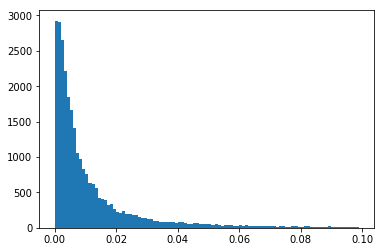

In [262]:
plt.hist(abs(differences), bins=np.arange(0,0.1, 0.001))

Mean and standard deviation of differences

In [261]:
print(abs(np.mean(differences)))
print(np.std(differences))

0.0009285993184722421
0.029954465637464657


In [263]:
# number of genes with differences that are greater than 0.05
# total number of scores being compared is 28172
(differences>0.05).sum()

847

In [173]:
item_index = np.where(differences>0.05)

## Exploring these differences 
what is driving this? 

In [223]:
diff_ac = [i for sublist in diff_activity for i in sublist]
hic_a = [i for sublist in diff_hic for i in sublist]
print(len(gene))
gene_a = [i for sublist in gene for i in sublist]
print(len(gene_tss))
tss_a = [i for sublist in gene_tss for i in sublist]

3133
3133


In [224]:
hic=[]
activity=[]
diff_a=[]
gene_tss_a=[]
gene_name_a=[]

for i in item_index[0]:
    gene_tss_a.append(tss_a[i])
    gene_name_a.append(gene_a[i])
    hic.append(hic_a[i])
    activity.append(diff_ac[i])
    diff_a.append(differences[i])

Looked at the genes w/ the top five largest differences

In [266]:
# Where all the differences are calculated via Jesse's ABC_SCORE - K_ABC_SCORE
# These are for the 847 differences, looking at the top 5 greatest differences

diff_df = {'gene':gene_name_a, 'gene_TSS': gene_tss_a, 'hic_diff' : hic, 'ac_diff': activity, 'diff_in_score': diff_a}
diff_df_2 = pd.DataFrame(diff_df)
sorted_df = diff_df_2.sort_values(by=['diff_in_score'], ascending=True)
print(sorted_df[:5])
data_4 = pd.read_csv("../EnhancerPredictions/EnhancerPredictions_4May.txt", sep='\t')
data_4_a = data_4.drop_duplicates(['chr', 'start', 'end', 'TargetGene', 'ABC.Score'])
concerned_sections = data_4_a[['chr', 'start', 'end', 'TargetGene', 'TargetGeneTSS', 'hic.distance.adj', 'activity_base','ABC.Score']]

      gene   gene_TSS  hic_diff  ac_diff  diff_in_score
12   WDR37    2205550    0.0000 -25.2908        -0.3314
11    IDI1    2205312    0.0000 -25.2908        -0.3314
107  SLMAP  346457892  -84.3168   4.0010        -0.2968
65   ALDOA   90227451    0.0000 -15.1983        -0.2780
7    PRMT6  107599266    0.0000  -5.7227        -0.2718


In [28]:
# Results from Jesse's Table S6
ac_data.loc[(ac_data['TargetGene']=='SLMAP')]

,chr,start,end,TargetGene,TargetGeneTSS,Normalized_HiC_Contacts,Activity,ABC_Score
21845,chr3,58045225.0,58045765.0,SLMAP,57875640.0,13.1653,3.9599,0.0350
21846,chr3,58147385.0,58147905.0,SLMAP,57875640.0,4.7558,12.6859,0.0405
21847,chr3,57740885.0,57742145.0,SLMAP,57875640.0,3.6832,14.2817,0.0353
21848,chr3,57937145.0,57937665.0,SLMAP,57875640.0,15.6832,4.2632,0.0449
21849,chr3,57791385.0,57791885.0,SLMAP,57875640.0,13.3830,4.2804,0.0385
21850,chr3,57921165.0,57921665.0,SLMAP,57875640.0,15.0048,4.5058,0.0454


In [288]:
# My scores 
data_6.loc[data_6['TargetGene']=='SLMAP']

,chr,start,end,TargetGene,TargetGeneTSS,class,hic.distance.adj,activity_base,ABC.Score
7250,chr3,57790980,57791880,SLMAP,57742982,genic,19.0307,5.7783,0.0366
7251,chr3,57773900,57774420,SLMAP,57742982,genic,28.0834,4.4116,0.0412
7252,chr3,57740926,57741440,SLMAP,57742982,intergenic,100.0000,1.8783,0.0625
7253,chr3,57743680,57744195,SLMAP,57742982,genic,100.0000,0.9908,0.0330
7254,chr3,57739380,57739920,SLMAP,57742982,intergenic,91.5542,1.7429,0.0531
7255,chr3,57741660,57742160,SLMAP,57742982,intergenic,100.0000,10.2807,0.3422


A lot of what drives the differences in HiC distance and activity is really dependent on the TargetGene's TSS
given the ABC model's sensitivity to the Transcription start sites of the gene you feed it.

For SLMAP, it seems like it was just a difference in the TargetGene TSS being chosen 

In [283]:
# My previous scores not excluding isoforms of genes 
concerned_sections.loc[concerned_sections['TargetGene']=='SLMAP']

,chr,start,end,TargetGene,TargetGeneTSS,hic.distance.adj,activity_base,ABC.Score
28270,chr3,57790980,57791880,SLMAP,57742982,19.0307,5.7783,0.0366
28271,chr3,57773900,57774420,SLMAP,57742982,28.0834,4.4116,0.0412
28272,chr3,57740926,57741440,SLMAP,57742982,100.0000,1.8783,0.0625
28273,chr3,57743680,57744195,SLMAP,57742982,100.0000,0.9908,0.0330
28274,chr3,57739380,57739920,SLMAP,57742982,91.5542,1.7429,0.0531
28275,chr3,57741660,57742160,SLMAP,57742982,100.0000,10.2807,0.3422
28282,chr3,57790980,57791880,SLMAP,57875640,13.4523,5.7783,0.0532
28283,chr3,57773900,57774420,SLMAP,57875640,7.5219,4.4116,0.0227
28284,chr3,57921180,57921680,SLMAP,57875640,15.0741,4.5487,0.0469
28285,chr3,58045240,58045767,SLMAP,57875640,13.2346,4.4989,0.0407


For other genes, like WDR37 and PRMT6 , there is a big difference in scores and enhancer regions! 

In [29]:
ac_data.loc[(ac_data['TargetGene']=='WDR37')]

,chr,start,end,TargetGene,TargetGeneTSS,Normalized_HiC_Contacts,Activity,ABC_Score
3101,chr10,1095985.0,1096485.0,WDR37,1102775.0,100.0,1.5003,0.0378
3102,chr10,1103885.0,1104465.0,WDR37,1102775.0,100.0,1.2096,0.0305


In [297]:
data_6.loc[data_6['TargetGene']=='WDR37']

,chr,start,end,TargetGene,TargetGeneTSS,class,hic.distance.adj,activity_base,ABC.Score
16915,chr10,1094327,1095580,WDR37,1102775,genic,37.9997,26.7911,0.3692
16916,chr10,1096020,1096520,WDR37,1102775,genic,100.0000,1.1702,0.0424


In [31]:
ac_data.loc[(ac_data['TargetGene']=="PRMT6")]

,chr,start,end,TargetGene,TargetGeneTSS,Normalized_HiC_Contacts,Activity,ABC_Score
1569,chr1,108000000.0,108000000.0,PRMT6,108000000.0,100.0,1.7432,0.0925


In [296]:
data_6.loc[data_6['TargetGene']=='PRMT6']

,chr,start,end,TargetGene,TargetGeneTSS,class,hic.distance.adj,activity_base,ABC.Score
1923,chr1,107599900,107601220,PRMT6,107599266,genic,100.0,7.4659,0.3643
